---

<center>
<h1>Pronóstico de la productividad forrajera </h1>
<h1>en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of neuronal networks as a tool for predicting forage production in the grasslands of Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. 

---

# Modules 

This section contains the import statements for external and in house Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [1]:
### Load the modules ### 
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets

### Load In-House modules ###  
sys.path.append('../src/')
import data
import reporting
import models


--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [2]:
PPNA_DENSE_FILE = 'PPNA_denso_16d_fechas_ordenadas.csv'
TEMP_DENSE_FILE = 'TEMP_denso_16d_fechas_ordenadas.csv'
PPT_DENSE_FILE  = 'PPT_denso_16d_fechas_ordenadas.csv'
CORD_DENSE_FILE = 'xy_denso.csv'
PPNA_SCRAGGLY_FILE = 'PPNA_ralo_16d_fechas_ordenadas.csv'
TEMP_SCRAGGLY_FILE = 'TEMP_ralo_16d_fechas_ordenadas.csv'
PPT_SCRAGGLY_FILE  = 'PPT_ralo_16d_fechas_ordenadas.csv'
CORD_SCRAGGLY_FILE = 'xy_ralo.csv'
DATE_FILE = 'fechas modis ANII.csv'

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [4]:
ppna_dense_df = data.ppna_database_ingest(PPNA_DENSE_FILE,0)
ppna_dense_df['dense']=1
temp_dense_df = data.temp_database_ingest(TEMP_DENSE_FILE,0)
ppt_dense_df = data.ppt_database_ingest(PPT_DENSE_FILE,0)
cord_dense_df = data.cord_database_ingest (CORD_DENSE_FILE, 0)

ppna_scraggly_df = data.ppna_database_ingest(PPNA_SCRAGGLY_FILE, len(cord_dense_df))
ppna_scraggly_df['dense']=0
temp_scraggly_df = data.temp_database_ingest(TEMP_SCRAGGLY_FILE, len(cord_dense_df))
ppt_scraggly_df = data.ppt_database_ingest(PPT_SCRAGGLY_FILE,len(cord_dense_df))
cord_scraggly_df = data.cord_database_ingest (CORD_SCRAGGLY_FILE, len(cord_dense_df))

date_df = data.date_database_ingest(DATE_FILE)

temp_df = pd.concat([temp_dense_df, temp_scraggly_df], ignore_index=True)
ppt_df = pd.concat([ppt_dense_df, ppt_scraggly_df], ignore_index=True)
cord_df = pd.concat([cord_dense_df, cord_scraggly_df], ignore_index=True)
ppna_df = pd.concat([ppna_dense_df, ppna_scraggly_df], ignore_index=True)

ppna_df = data.DataManager(data.merge_databases(ppna_df,temp_df,ppt_df,cord_df,date_df))
ppna_df.info()

<class 'data.data_manager.DataManager'>
RangeIndex: 5520000 entries, 0 to 5519999
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ppna       float64       
 1   temp       float64       
 2   ppt        float64       
 3   date       datetime64[ns]
 4   latitude   float64       
 5   longitude  float64       
 6   dense      int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 294.8 MB


In [8]:
ppna_scraggly_df 

,id_date,id_cord,ppna,dense
0,1,0,246.750028,0
1,2,0,329.5719991,0
2,3,0,285.9922566,0
3,4,0,245.589701,0
4,5,0,257.4281617,0
...,...,...,...,...
689995,456,1499,415.3899301,0
689996,457,1499,459.2578315,0
689997,458,1499,336.0955167,0
689998,459,1499,418.0946419,0


In [5]:
ppna_df[0:1000]

,ppna,temp,ppt,date,latitude,longitude,dense
0,405.340618,24.333897,76.155505,2001-01-01,-31.544792,-56.83242,1
1,246.750028,24.333897,76.155505,2001-01-01,-31.544792,-56.83242,0
2,405.340618,25.019988,76.155505,2001-01-01,-31.544792,-56.83242,1
3,246.750028,25.019988,76.155505,2001-01-01,-31.544792,-56.83242,0
4,405.340618,24.333897,89.430279,2001-01-01,-31.544792,-56.83242,1
...,...,...,...,...,...,...,...
995,84.920559,13.868956,124.568974,2006-05-25,-31.544792,-56.83242,0
996,102.437194,14.992404,65.087910,2006-05-25,-31.544792,-56.83242,1
997,84.920559,14.992404,65.087910,2006-05-25,-31.544792,-56.83242,0
998,102.437194,13.868956,65.087910,2006-05-25,-31.544792,-56.83242,1



## Data Visualization 


In [4]:
ppna_df.head()

,ppna,temp,ppt,date,latitude,longitude,dense
0,405.340618,24.333897,76.155505,2001-01-01,-31.544792,-56.832420,1
1,405.340618,24.333897,76.155505,2001-01-01,-33.151042,-56.616383,1
2,246.750028,24.333897,76.155505,2001-01-01,-31.544792,-56.832420,0
3,246.750028,24.333897,76.155505,2001-01-01,-33.151042,-56.616383,0
4,405.340618,25.019988,76.155505,2001-01-01,-31.544792,-56.832420,1


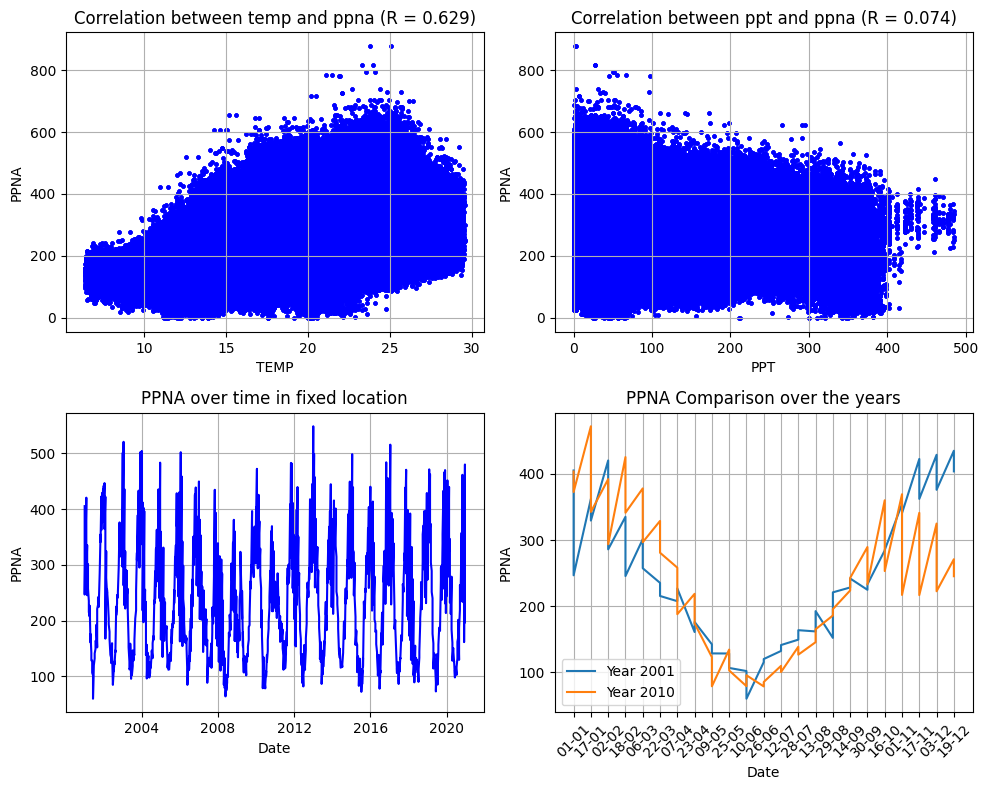

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

reporting.show_correlation(ppna_df, axes[0,0], 'temp', 'ppna')
reporting.show_correlation(ppna_df, axes[0,1], 'ppt', 'ppna')
reporting.show_ppna_fixed_position(ppna_df, axes[1,0], ppna_df['latitude'][100], ppna_df['longitude'][100])
reporting.show_ppna_year_comparision_fixed_position(ppna_df,axes[1,1], 2001, 2010, ppna_df['latitude'][0], ppna_df['longitude'][0])

fig.tight_layout()
plt.show()

## Data Management


Time in seconds isn't the most helpful input for our model, especially when dealing with meteorological data, 
which tends to exhibit periodic patterns. To better understand these patterns, we employ Fourier analysis, revealing a distinct annual cycle.

Addressing this periodicity involves various strategies. Our approach involves transforming date inputs into sine and cosine functions. 
Through prior examination, we've determined that the most significant time dependency occurs on an annual basis. Consequently, we'll utilize a time signal with an annual period.

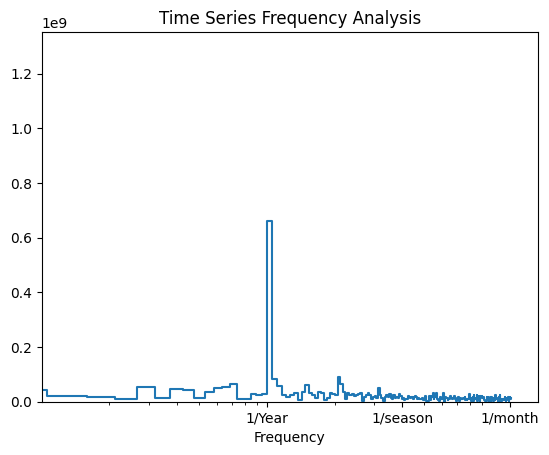

Text(0.5, 1.0, 'Time signal')

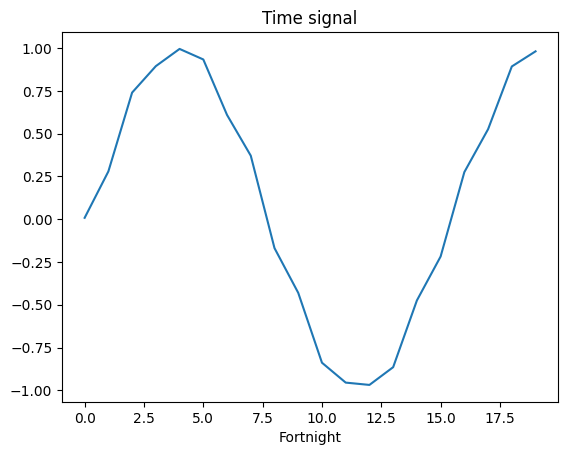

In [6]:
#Convert from date to timestamp format
ppna_df.date_to_timestamp()

# group dataframe by date 
combined_series = ppna_df.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset


plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

day = 24*60*60
year = (365.2425)*day


ppna_df['date_signal'] = np.sin(ppna_df['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df['date_signal'])[:480:24]) #25 samples is nearly a year (15 * 24 = 360 days) and is shown to represent a full period of the temporal signal.
plt.xlabel('Fortnight')
plt.title('Time signal')


Afterwards, the dataframe are divided into three sections (train, test, validation) with roughly a 70-20-10 distribution. As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%, 20% and 10%). The samples are divided secuentially to improve the RNN performance, following a training - validation - testing order.

- The **training set** is going to be fed to the model in order for it to learn the distinctive patterns and causalities for the input data and the future ppna.

- The **validation set** provides a way for the model to evaluate it's predictive capability and check if it is not just learning how to handle training data.

- The **testing set** is used further along the way, as a way to test the model's predictive effectieness with data that it has never seen before.

The resulting distribution of the dataset will resemble the following graph.

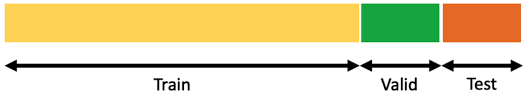


In [10]:
ppna_df.sort_values(by=['latitude', 'date'])

,ppna,temp,ppt,date,latitude,longitude,dense,timestamp_date,date_signal
3650560,442.888225,24.534138,79.341238,2001-01-01,-33.230208,-56.147042,1,9.783072e+08,0.008300
3650562,327.906853,24.534138,79.341238,2001-01-01,-33.230208,-56.147042,0,9.783072e+08,0.008300
3650564,442.888225,24.466445,79.341238,2001-01-01,-33.230208,-56.147042,1,9.783072e+08,0.008300
3650566,327.906853,24.466445,79.341238,2001-01-01,-33.230208,-56.147042,0,9.783072e+08,0.008300
3650568,442.888225,24.534138,63.376083,2001-01-01,-33.230208,-56.147042,1,9.783072e+08,0.008300
...,...,...,...,...,...,...,...,...,...
831670,282.720509,23.343935,57.395967,2020-12-18,-30.113542,-56.966766,0,1.608250e+09,-0.227937
831672,427.906834,25.299566,29.325179,2020-12-18,-30.113542,-56.966766,1,1.608250e+09,-0.227937
831674,282.720509,25.299566,29.325179,2020-12-18,-30.113542,-56.966766,0,1.608250e+09,-0.227937
831676,427.906834,23.343935,29.325179,2020-12-18,-30.113542,-56.966766,1,1.608250e+09,-0.227937


In [7]:
train_df = data.DataManager(ppna_df[ppna_df['date'] < '2014-01-01'][[ 'date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])
val_df =  data.DataManager(ppna_df[(ppna_df['date'] >= '2014-01-01') & (ppna_df['date'] < '2019-01-01')][[ 'date_signal', 'latitude', 'longitude', 'ppt', 'temp', 'ppna']])
test_df = data.DataManager(ppna_df[ppna_df['date'] >= '2019-01-01'][['date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])

KeyboardInterrupt: 

Finally, normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26

https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

In [9]:
train_mean, train_std = train_df.normalize_data()
val_mean, val_std = val_df.normalize_data()
test_mean, test_std = test_df.normalize_data()

--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating and predicting the productivity of forage production. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

The RNN technology is capable of pondering wether the inputs are correlated with eachother or not. It also has te ability to set cycles that constitute an "internal memory" that allows comparisons between the current data being analysed and the previous ones. This cycles, represented as delays, and the whole RNN structure are depicted in the following image.

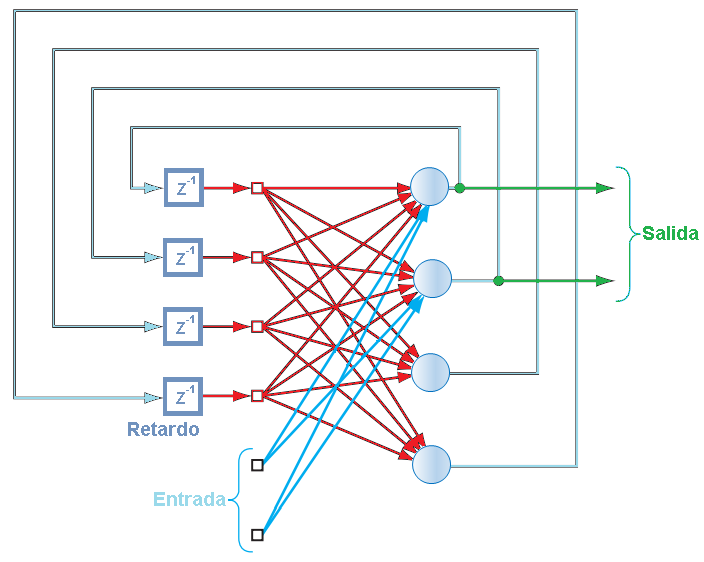



## LSTM - Multivariable 

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPNA. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

A recurrent model can learn to use a long history of inputs if it is relevant for the predictions the model makes. 
Here, the model will accumulate internal state over a year (24 samples) before making a single prediction for the next 15 days (1 sample).

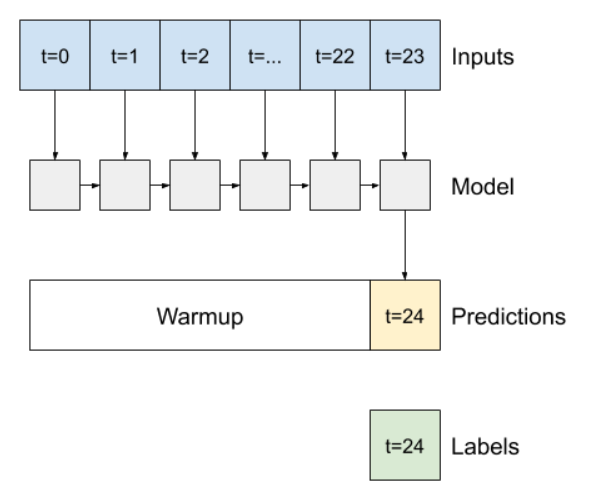

In [10]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #The amount of days to be forecasted is given by the equation 15*OUTPUT_STEPS = # of days
train_sequence, train_labels = train_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence, val_labels = val_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence, test_labels = test_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels.shape)

In this section, every model tested has at least one LSTM layer, so let's remember how they work.

Long Short Term Memory is a type of neural network designed to solve the Vanishing Gradient problem and the Exploding Gradient Problem that the basic Recurrent Neural Network posed. The structure of a single unit is 

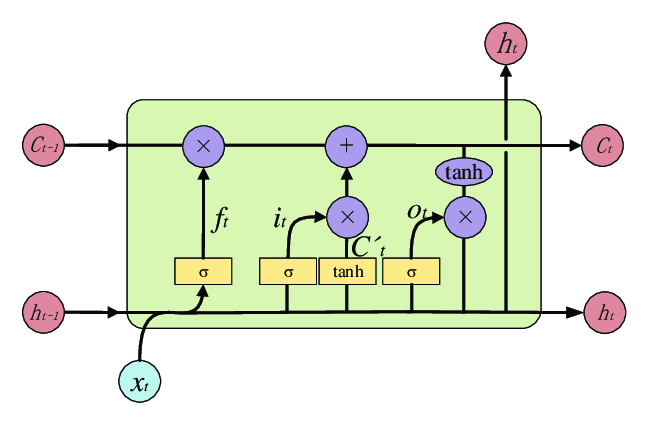

On the left side we can see the input data that arrives to the layer, which requires temporal info. x_t represents the information from the previous LSTM unit. On the right, the outputs of the unit serve as the inputs for the following step. Inside the square, the point is to make the Neural Network remember the important information and for it to "forget" the rest. As the time frame progresses, the oldest data starts to loose it's value and the LSTM unit filters it with the sigmoid functions, which act as a valve for the data flow. The tanh functions allow the new information to be passed on with a certain weight to represent it's importance.

In [12]:
"""
If you want to create a new model it has to be defined in /src/model
"""
model= models.modelLstm(INPUT_STEPS, OUTPUT_STEPS, train_df.shape[1], 1)

"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.

EPOCHS = 5
history = model.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32)
model.save('../models/modelLstm128')

"""
#If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code 
modelName = 'modelLstm128'
model = tf.keras.models.load_model(f'../models/{modelName}')


Now we will plot the values of root mean squared error and loss for each epoch regarding the training and validation set. 

- The squared error provides a clear way to evaluate how the predictions are going to relate to the actual values. Hence, we want it as close to 0 as possible.
- The loss value, however, is not to be overlooked. It remains a key factor to determine wether the model is overfitting or not. There are two main aspects to be aware of: first, we don't want the validation loss to grow over time, as that means the model is becoming too familiar with the training data and therefore starts losing it's ability to predict. Furthermore, we want for both validation loss and training loss to be similar, as in that case the model will be accurate in predicting training labels but not anything else, resulting in overfitting.

NameError: name 'history' is not defined

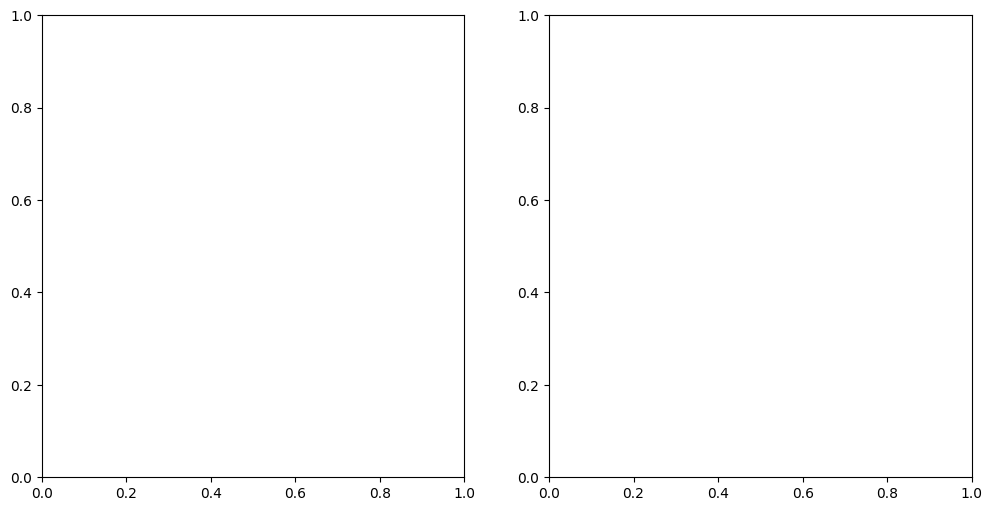

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot training history
reporting.plot_training_history(axes[0], history, "root_mean_squared_error")
reporting.plot_training_history(axes[1], history, "loss")

fig.suptitle("Training History")
fig.tight_layout()
plt.show()


Now it's time to see how the model behaves in the testing phase. To do so, we can plot the predicted values for a fixed position next to the measured ones for the first 6 months of the testing dataset. As the model has never seen said values before, the result may show accurately it's performance. The chosen position is completely arbitrary and can be replicated for every point in the dataset, although in theory the precission should be statistically similar.

In [13]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    reporting.plot_result_in_fixed_position(axes[0,0],ppna_df['longitude'][400000], ppna_df['latitude'][400000],index, model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[0,1],ppna_df['longitude'][0], ppna_df['latitude'][0],index,  model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,0],ppna_df['longitude'][10000], ppna_df['latitude'][10000],index,  model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,1],ppna_df['longitude'][30000], ppna_df['latitude'][30000],index,   model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    


widgets.interactive(update_plot, index=index_slider)

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…